EdgeDetect runtime: 9.187899351119995


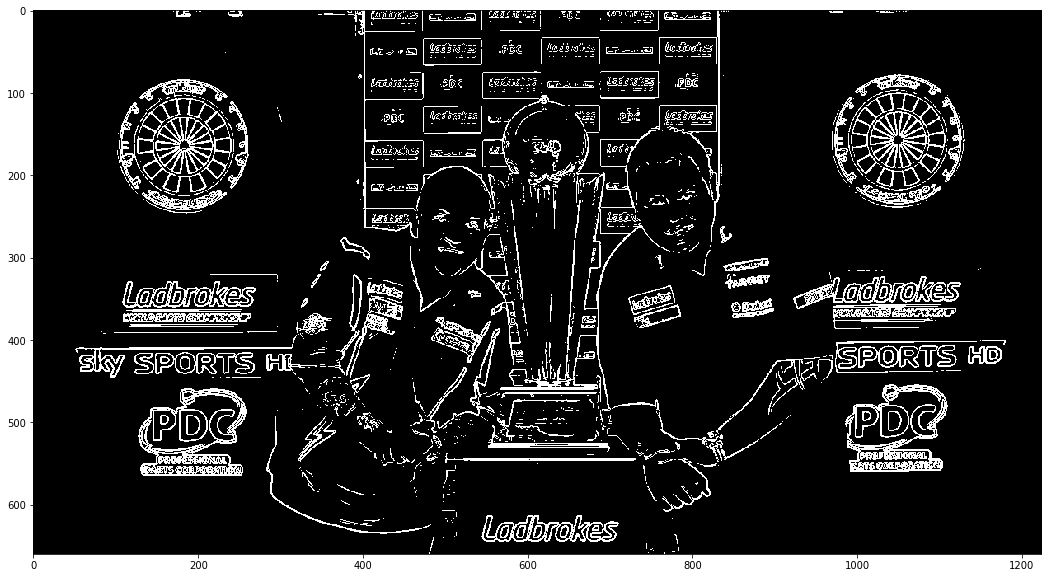

In [14]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import cv2
import math
import time

pylab.rcParams['figure.figsize'] = (20,10)


def imshow(image):
    #OpenCV stores images in BGR so we have to convert to RGB to display it using matplotlib
    imagergb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(imagergb)
    plt.show()


def EdgeDetect (img, threshmult):

    #Applying the Sobel Operator (try rewrite using own sobel)

    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)

    (M,N) = sobelx.shape
    grad = np.zeros((M,N))
    direc = np.zeros((M,N))

    thresh = threshmult*np.sum(img)/(N*M) #the higher the quicker, but risk not representing edges

    for m in range (0,M): #m = y
        for n in range  (0,N): # n = x
            grad[m,n] = math.sqrt(sobelx[m,n]**2 + sobely[m,n]**2)
            if sobelx[m,n] == 0: # to prevent division by zero in direc
                sobelx[m,n]= 1*10**(-5)
            direc[m,n] = np.arctan(sobely[m,n]/sobelx[m,n])
            if grad[m,n]>thresh:
                grad[m,n] = 255
            else:
                grad[m,n] = 0
                direc[m,n] = 0
#     FaceRemove (img, grad, direc)
    return grad, direc
    

def FaceRemove (img, grad, direc):
    
    face_classifier = cv2.CascadeClassifier('frontalface.xml')
    # face_classifier = cv2.CascadeClassifier('./Haarcascades/haarcascade_frontalface_default.xml')
    faces = face_classifier.detectMultiScale(img, 1.1, 1, 0, (30,30), (200,200))

    if faces is ():
        print('No faces found')
    else:
        for (X,Y,W,H) in faces:
            for y in range (Y,Y+H):
                for x in range (X,X+W):
                    grad[y,x] = 0
                    direc[y,x] = 0
    return grad
                
i = 14
location = str("../images/dart") + str(i) + str(".jpg")
imgcol = cv2.imread(location)
img = cv2.cvtColor(imgcol, cv2.COLOR_BGR2GRAY)
stime = time.time()
grad, direc = EdgeDetect (img, 3)
print ("EdgeDetect runtime: " + str(time.time() - stime) )

saveloc = (str("nofaceedge/dartnofaceedge" + str(i) + str(".jpg")))
cv2.imwrite(saveloc,grad)
plt.imshow(grad, cmap='gray')


In [15]:
#Hough Circle

def HTCircle (grad, direc, minrad, maxrad):
    
    nc =  maxrad-minrad #num circles
    (M,N) = grad.shape
    rad = np.zeros(nc-minrad)
    for a in range (0,nc-minrad):
        rad[a] = (a+minrad+1)*maxrad/nc

    Hxyr = np.zeros ((M,N,nc))
    total= M*N

    deg = math.pi/180
    for m in range (0,M): #y
        for n in range (0,N): #x
            if grad[m,n] == 255:
                for r in rad:

                    # optimisation of the for loop to only cater for the top left quarter of a circle to its center
                    y0 = int(np.round(m + r*math.sin(direc[m,n])))
                    x0 = int(np.round(n + r*math.cos(direc[m,n])))

                    # to cater for noise we +/- 1 degree
                    y1 = int(np.round(m + r*math.sin(direc[m,n]+deg)))
                    x1 = int(np.round(n + r*math.cos(direc[m,n]+deg)))
                    y2 = int(np.round(m + r*math.sin(direc[m,n]-deg)))
                    x2 = int(np.round(n + r*math.cos(direc[m,n]-deg)))

                    # removing 2 if statements to speed up the loop
                    dx = 2*abs(x2-x1)
                    dy = 2*abs(y2-y1)
                    radindex = int(nc*r/maxrad -(minrad+1))

                    if dy<=y0<M-dy and dx<=x0<N-dx:
                        Hxyr[y0,x0,radindex] += 1
                        Hxyr[y1,x1,radindex] += 1
                        Hxyr[y2,x2,radindex] += 1
                    else:
                        break #break to prevent unecessary calculation wiht larger r values
    return Hxyr

minrad = 10
maxrad = 100

stime = time.time()
Hxyr = HTCircle(grad, direc, minrad, maxrad)
etime = time.time()
print("runtime: Hough Transform " + str(etime-stime))

runtime: Hough Transform 418.5290460586548


In [16]:
#Creating Hough Space

def HSpace (Hxyr):
    (a,b,c) = Hxyr.shape #to calculate the no of elements
    Hspace = np.zeros((a,b))

    for y in range (0,a):
        for x in range (0,b):
            sum = 0
            for z in range (0,c):
                sum += Hxyr[y,x,z]
            Hspace[y,x] = sum

    #normalising the values
    norm = np.amax(Hspace)
    Hspace = Hspace*255/norm
    return Hspace

stime = time.time()
Hspace = HSpace(Hxyr)
print ("Hough Space Runtime: " + str(time.time()-stime))

Hough Space Runtime: 35.03490209579468


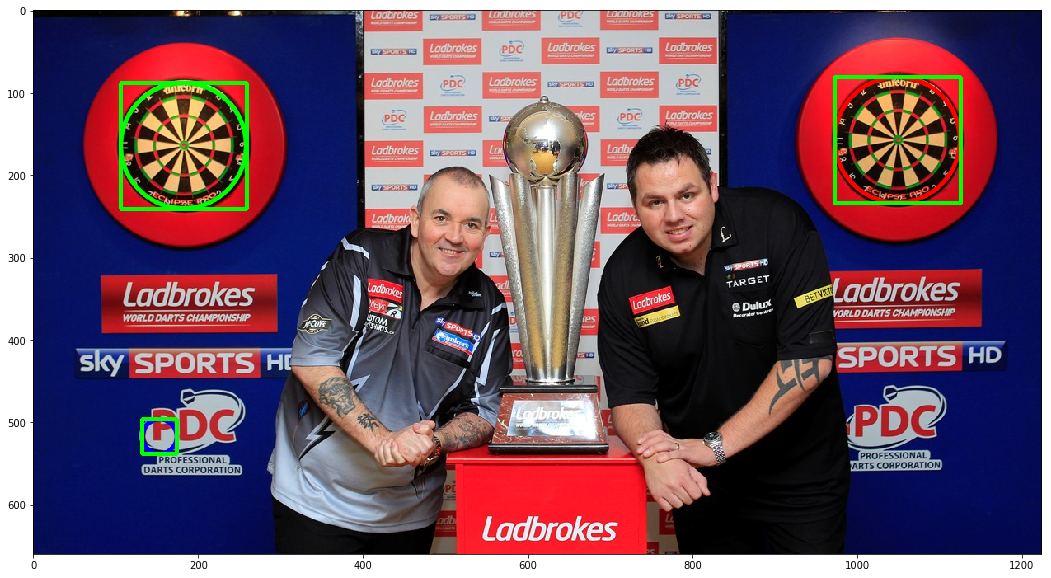

In [17]:
def PlotCircle (imgcol, Hxyr, Hspace, minrad, maxrad):
    
    nc =  maxrad-minrad #num circles
    (a,b) = Hspace.shape #for later to calculate the highest index of the flattened array
    argordH = Hspace.argsort(axis=None) #lists the indices in accending order of value (array is flattened)

    index = 1
    #in order to detect images with multiple dart boards, we find the top highest Hspace values that dont have 

#circle0
    (y0,x0)=np.unravel_index(argordH[a*b-index], (a,b)) #unravels the flattened value back into a tuple for the nth highest
    amax = Hxyr[y0,x0].shape
    argordxyr = Hxyr[y0,x0].argsort(axis=None)
    rindex = argordxyr[amax[0]*1-1]
    r = (rindex+minrad+1)*maxrad/nc
    cv2.circle(imgcol, (x0,y0), int(r), (0,255,0), 3, cv2.LINE_AA)
    
    circle0 = (x0-int(r),y0-int(r),int(2*r),int(2*r))
#     circle0 = np.zeros((2*int(r), 2*int(r), 2))
#     for p in range (0,int(2*r)):
#         for q in range (0,int(2*r)):
#             circle0[p,q] = (y0-int(r)+p, x0-int(r)+q)

#circle1
    index += 1
    for c in range(index, a*b):
        (y,x)=np.unravel_index(argordH[a*b-c], (a,b)) #unravels the flattened value back into a tuple for the nth highest
        if math.sqrt((x0-x)**2 + (y0-y)**2)>20:
            index = c
            break

    (y1,x1)=np.unravel_index(argordH[a*b-index], (a,b)) #unravels the flattened value back into a tuple for the nth highest
    amax = Hxyr[y1,x1].shape
    argordxyr = Hxyr[y1,x1].argsort(axis=None)
    rindex = argordxyr[amax[0]*1-1]
    r = (rindex+minrad+1)*maxrad/nc
    cv2.circle(imgcol, (x1,y1), int(r), (0,0,255), 3, cv2.LINE_AA)
    
    circle1 = (x1-int(r),y1-int(r),int(2*r),int(2*r))
#     circle1 = np.zeros((2*int(r), 2*int(r), 2))
#     for p in range (0,int(2*r)):
#         for q in range (0,int(2*r)):
#             circle1[p,q] = (y1-int(r)+p, x1-int(r)+q)

#circle2
    for c in range(index, a*b):
        (y,x)=np.unravel_index(argordH[a*b-c], (a,b)) #unravels the flattened value back into a tuple for the nth highest
        if math.sqrt((x0-x)**2 + (y0-y)**2)>20 and math.sqrt((x1-x)**2 + (y1-y)**2)>50:
            index = c
            break

    (y2,x2)=np.unravel_index(argordH[a*b-index], (a,b)) #unravels the flattened value back into a tuple for the nth highest
    amax = Hxyr[y2,x2].shape
    argordxyr = Hxyr[y2,x2].argsort(axis=None)
    rindex = argordxyr[amax[0]*1-1]
    r = (rindex+minrad+1)*maxrad/nc
    cv2.circle(imgcol, (x2,y2), int(r), (255,0,0), 3, cv2.LINE_AA)

    circle2 = (x2-int(r),y2-int(r),int(2*r),int(2*r))
#     circle2 = np.zeros((2*int(r), 2*int(r), 2))
#     for p in range (0,int(2*r)):
#         for q in range (0,int(2*r)):
#             circle2[p,q] = (y2-int(r)+p, x2-int(r)+q)
            

    return circle0, circle1, circle2

imgcol = cv2.imread(location)

circle0, circle1, circle2 = PlotCircle(imgcol, Hxyr, Hspace, minrad, maxrad)

dart_HT = np.array([circle0,circle1,circle2])

for (x,y,w,h) in dart_HT:
        cv2.rectangle(imgcol, (x,y), (x+w,y+h), (0,255,0), 3)
        
imshow(imgcol)

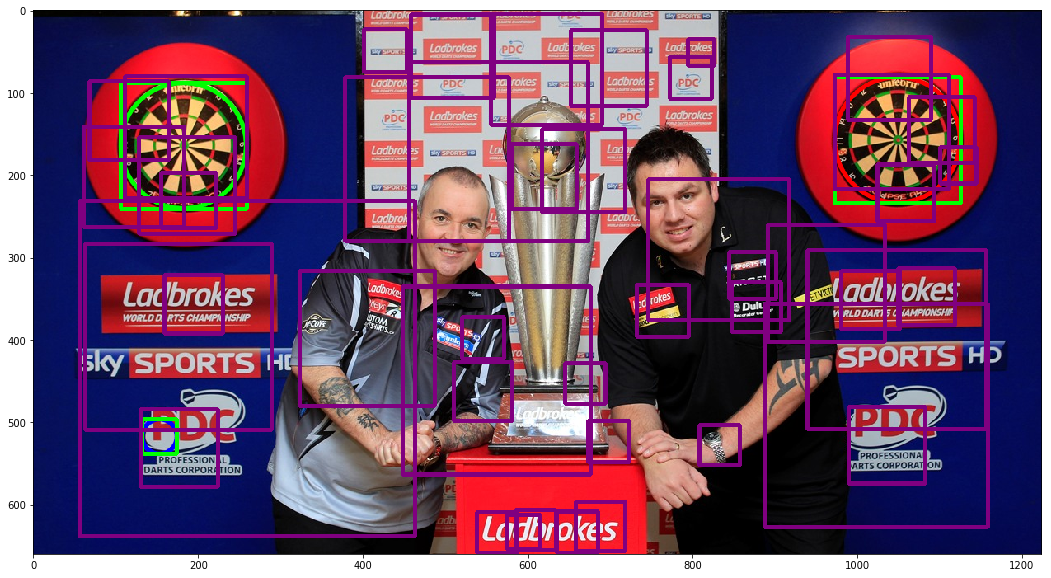

In [18]:
def ViolaJones (i):
    obj_classifier = cv2.CascadeClassifier('cascade.xml')
    location = str("../images/dart") + str(i) + str(".jpg")
    image = cv2.imread(location)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)    
    #run classifier
    obj = obj_classifier.detectMultiScale(gray, 1.1, 1, 0, (20,20), (500,500))
    return obj

dart_VJ = ViolaJones(i)
for (x,y,w,h) in dart_VJ:
        cv2.rectangle(imgcol, (x,y), (x+w,y+h), (128,0,128), 3)
imshow(imgcol)

(111, 80, 148, 148)
(972, 78, 139, 139)
(61, 141, 122, 122)
(128, 154, 117, 117)


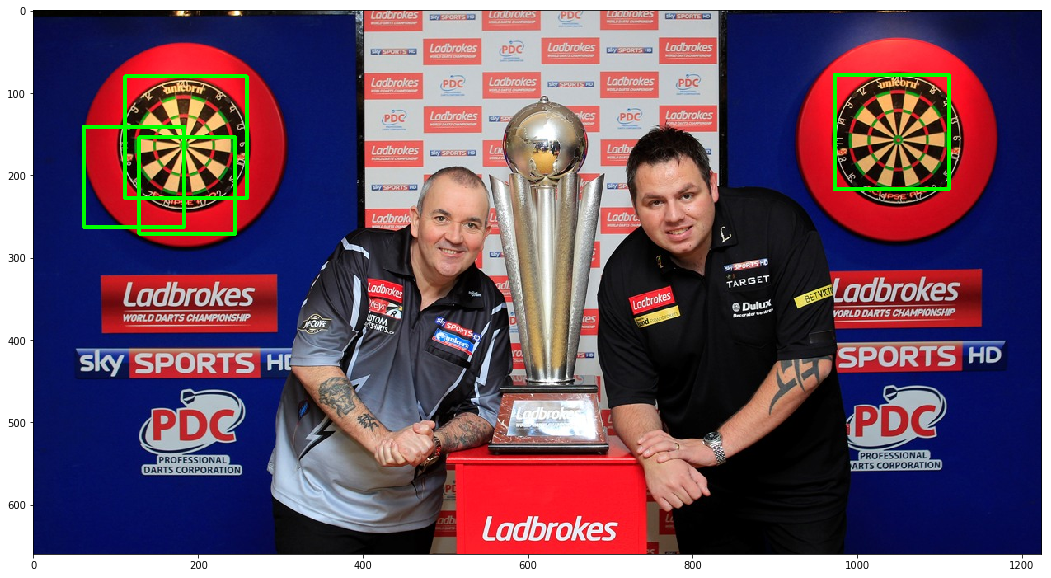

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [19]:
def Compare (A,B):
    Area = np.zeros((len(A),len(B)))
    
    for ai in range (len(A)):
        for bi in range (len(B)):
            (x0,y0,w0,h0) = A[ai]
            (x1,y1,w1,h1) = B[bi]
            TotalA = w0*h0
            if x0<=x1 and y0<=y1:
                for xs in range(x0,x0+w0):
                    for ys in range (y0, y0+h0):
                        if xs==x1 and ys==y1:
                            w = w0-(x1-x0)
                            h = h0-(y1-y0)
                            if w>w1:
                                w = w1
                            if h>h1:
                                h = h1
                            Area[ai,bi] = w*h/TotalA
                            break
            elif x0>x1 and y0>y1:
                for xs in range (x1, x1+w1):
                    for ys in range(y1,y1+h1):
                        if xs==x0 and ys==y0:
                            w = w1-(x0-x1)
                            h = h1-(y0-y1)
                            if w>w0:
                                w = w0
                            if h>h0:
                                h = h0
                            Area[ai,bi] = w*h/TotalA
                            break
            elif x0<=x1:
                for xs in range(x0, x0+w0):
                    if xs==x1:
                            w = w0 - (x1-x0)
                            h = h1 - (y0-y1)
                            if w>w1:
                                w = w1
                            if h>h0:
                                h = h0
                            Area[ai,bi] = w*h/TotalA
                            break
            elif y0<=y1: 
                for xs in range(x1, x1+w1):
                    if xs == x0:
                            w = w1 - (x0-x1)
                            h = h0 - (y1-y0)
                            if w>w0:
                                w = w0
                            if h>h1:
                                h = h1
                            Area[ai,bi] = w*h/TotalA
                            break
            else: 
                print('missing case/condition')            
    return Area

def Eval (A,B,imgcol,thresh=0.4): #Geometric F1 Score
    judge = np.zeros((len(A),len(B)))
    Area = Compare (A,B)
    Areainv = Compare (B,A)
    for a in range (len(A)):
        for b in range (len(B)):
            p = Area[a,b]
            r = Areainv[b,a]
            if (p+r) ==0:
                judge[a,b] = 0
            elif 2*p*r/(p+r)>thresh:
                judge[a,b]= 1
                (x,y,w,h) = A[a]
                print ((x,y,w,h))
                cv2.rectangle(imgcol, (x,y) , (x+w,y+h),(0,255,0), 3)
                
    return judge

location = str("../images/dart") + str(i) + str(".jpg")
imgcol = cv2.imread(location)
judge = Eval (dart_VJ,dart_HT, imgcol)
imshow(imgcol)
print (judge)

#Hough Lines

def HTLines (circle, grad, direc, numlines=360):    
    
    nl=numlines
    theta = np.zeros(nl)
    
    (x,y,r) = circle     
    (M,N) = grad.shape
    
    for a in range (0,nl):
        theta[a] = a*2*math.pi/nl

    #Hough space
    maxd = 2*math.sqrt(M**2 + N**2)
    Hroth = np.zeros((int(maxd), nl))
    
    for m in range (y-r, y+r):
        for n in range (x-r,x+r):
            if grad[m,n]==255:
                for t in theta:
                        ro = int(np.round(n*math.cos(t) + m*math.sin(t)))
                        tindex = int(np.round(t*nl/(2*math.pi)))
                        Hroth[ro,tindex] += 1        
    
    print (np.amax(Hroth))
    return Hroth
    
Hroth = HTLines (circle1, grad, direc)
plt.imshow(Hroth, cmap='gray')

#Drawing the most likely lines on the image
nl = 360
imgcol = cv2.imread(location)
(M,N) = img.shape    
(a,b) = Hroth.shape #for later to calculate the highest index of the flattened array
nth =  1 #number of green lines drawn
argord = Hroth.argsort(axis=None) #lists the indices in accending order of value (array is flattened) 
(roindex,tindex)=np.unravel_index(argord[a*b-nth], (a,b)) #unravels the flattened value back into a tuple for the nth highest 
thresh = Hroth[roindex,tindex]

stime = time.time()
for ro in range (0,a):
    for tindex in range (0,b):
        if Hroth[ro,tindex]>thresh:
            
            t = tindex*2*math.pi/nl
            if math.cos(t)==0:
                y1 = int(np.round(ro/math.sin(t)))
                x1 = 0
                y2 = y1
                x2 = N-1
                cv2.line(imgcol, (x1,y1),(x2,y2), (255,0,0), 5, cv2.LINE_AA)
                
            elif math.sin(t)==0:
                x1 = int(np.round(ro/math.cos(t)))
                y1 = 0
                x2 = x1
                y2 = M-1
                cv2.line(imgcol, (x1,y1),(x2,y2), (0,0,255), 5, cv2.LINE_AA)
            else:    
                x = int(np.round(ro/math.cos(t)))
                y = int(np.round(ro/math.sin(t)))
                m = y/x #gradient of line y = mx + c
                c = y - m*x
                x1 = 0
                y1 = int(c)
                x2 = N-1
                y2 = int(np.round(m*x2 + c))
                if y1<N and y2<N:
                    cv2.line(imgcol, (x1,y1),(x2,y2), (255,0,0), 1, cv2.LINE_AA)
                elif y1<N:
                    y2 = int(M-1)
                    x2 = int(np.round((y2-c)/m)) 
                    cv2.line(imgcol, (x1,y1),(x2,y2), (0,0,255), 1, cv2.LINE_AA)
                elif y2<N:
                    y1 = M-1
                    x1 = int(np.round((y1-c)/m))
                    cv2.line(imgcol, (x1,y1),(x2,y2), (0,255,0), 3, cv2.LINE_AA)
                else:
                    cv2.line(imgcol, (x1,y1),(x2,y2), (0,255,0), 3, cv2.LINE_AA)
            
etime = time.time()

print("runtime: " + str(etime-stime))               
imshow(imgcol)